In [3]:
!pip install torchvision

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [24]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet,self).__init__()
    self.cn1=nn.Conv2d(1,16,3,1)
    self.cn2=nn.Conv2d(16,32,3,1)
    self.dp1=nn.Dropout2d(0.10)
    self.dp2 = nn.Dropout2d(0.25)
    self.fc1=nn.Linear(4608,64)
    self.fc2=nn.Linear(64,10)

  def forward(self,x):
    x=self.cn1(x)
    x=F.relu(x)
    x=self.cn2(x)
    x=self.dp1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dp1(x)
    x=torch.flatten(x,1)
    x=self.fc1(x)
    x = F.relu(x)
    x = self.dp2(x)
    x=self.fc2(x)
    op=F.log_softmax(x,dim=1)
    return op

In [25]:
def train(model,device,train_dataloader,optim,epoch):
  model.train()
  for b_i, (X,y) in enumerate(train_dataloader):
    X,y=X.to(device),y.to(device)
    optim.zero_grad()
    pred_prob=model(X)
    loss=F.nll_loss(pred_prob,y)
    loss.backward()
    optim.step()
    if b_i%10==0:
      print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))



In [26]:
def test(model,device,test_dataloader):
  model.eval()
  loss=0
  success=0
  with torch.no_grad():
    for X,y in test_dataloader:
      X,y = X.to(device), y.to(device)
      pred_prob=model(X)
      loss+=F.nll_loss(pred_prob,y,reduction='sum').item()
      pred=pred_prob.argmax(dim=1,keepdim=True)
      success+=pred.eq(y.view_as(pred)).sum().item()
  loss /= len(test_dataloader.dataset)

  print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))


In [27]:
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))
                   ])),
    batch_size=500, shuffle=False)

In [28]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)


In [29]:
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.293381
epoch: 1 [320/60000 (1%)]	 training loss: 1.816214
epoch: 1 [640/60000 (1%)]	 training loss: 1.171479
epoch: 1 [960/60000 (2%)]	 training loss: 0.819485
epoch: 1 [1280/60000 (2%)]	 training loss: 0.739516
epoch: 1 [1600/60000 (3%)]	 training loss: 0.394021
epoch: 1 [1920/60000 (3%)]	 training loss: 0.465716
epoch: 1 [2240/60000 (4%)]	 training loss: 0.589886
epoch: 1 [2560/60000 (4%)]	 training loss: 0.354187
epoch: 1 [2880/60000 (5%)]	 training loss: 0.376631
epoch: 1 [3200/60000 (5%)]	 training loss: 0.544930
epoch: 1 [3520/60000 (6%)]	 training loss: 0.272909
epoch: 1 [3840/60000 (6%)]	 training loss: 0.428567
epoch: 1 [4160/60000 (7%)]	 training loss: 0.457157
epoch: 1 [4480/60000 (7%)]	 training loss: 0.264451
epoch: 1 [4800/60000 (8%)]	 training loss: 0.440254
epoch: 1 [5120/60000 (9%)]	 training loss: 0.075095
epoch: 1 [5440/60000 (9%)]	 training loss: 0.412936
epoch: 1 [5760/60000 (10%)]	 training loss: 0.129949
epoch: 1 [6080/60

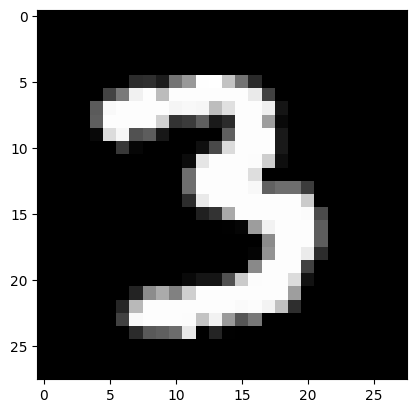

In [37]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()


In [31]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")


Model prediction is : 7
Ground truth is : 7
